# Topic modeling with Bertopic

In [16]:
pip install bertopic pandas numpy matplotlib plotly nbformat ipywidgets openpyxl nltk

Note: you may need to restart the kernel to use updated packages.


# Start 

In this tutorial, we will use the [`Bertopic`](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html) library to perform topic modeling on legislative text.


## Data

We will use a dataset of Donald Trump's tweets from 2009 to 2021. This dataset is available on [Kaggle](https://www.kaggle.com/datasets/austinreese/trump-tweets) and contains 43,000 tweets sent by Donald Trump. 

# Data Preprocessing

Social media messages are a common medium for applied computational methods and machine learning. However, they are often noisy and contain a lot of irrelevant information. In this tutorial, our aim is to use the `Bertopic` library to perform topic modeling on the tweets, but we first need to preprocess the data to remove any irrelevant information.


## What is topic modeling?

Topic modeling is a type of statistical model that is used to discover the abstract topics that occur in a collection of documents. It is an unsupervised machine learning technique that can be used to identify the main themes or topics in a large collection of text documents. We will use the `Bertopic` library, which relies on the BERT language model to perform topic modeling.

We expect that the tweets can be grouped into topics that correspond to the different areas of focus. Moreover, the data have a temporal dimension, which we will use to create dynamic topic models. While we will be focusing on the tweets of Donald Trump, the techniques we will use can be applied to any text data.

In [2]:
import pandas as pd 
import numpy as np 
from bertopic import BERTopic

In [126]:
# read in the data

df = pd.read_csv('../data/trump_tweets.csv')
df

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN
...,...,...,...,...,...,...,...,...
43347,1273405198698975232,https://twitter.com/realDonaldTrump/status/127...,Joe Biden was a TOTAL FAILURE in Government. H...,2020-06-17 19:00:32,23402,116377,NaN,NaN
43348,1273408026968457216,https://twitter.com/realDonaldTrump/status/127...,Will be interviewed on @ seanhannity tonight a...,2020-06-17 19:11:47,11810,56659,@seanhannity,NaN
43349,1273442195161387008,https://twitter.com/realDonaldTrump/status/127...,pic.twitter.com/3lm1spbU8X,2020-06-17 21:27:33,4959,19344,NaN,NaN
43350,1273442469066276864,https://twitter.com/realDonaldTrump/status/127...,pic.twitter.com/vpCE5MadUz,2020-06-17 21:28:38,4627,17022,NaN,NaN


In [127]:
# what does the text look like? 

df['content'].sample(20).values

array(['" @ Vinnie_109: @ WalkerLaflin @ katie_0303 we need @ realDonaldTrump to run and we would be good"',
       'pic.twitter.com/8lI2lomGkh',
       'Democrats are becoming the Party of late term abortion, high taxes, Open Borders and Crime!',
       'The @ TODAYshow refused to use their just in poll numbers where I have a massive lead but instead used @ CNN numbers where my lead is smaller.',
       'I really like Chelsea Clinton--an amazing young woman. She got the best of both parents. ( @ IvankaTrump agrees)',
       '"Right now, we are running a massive $300 billion trade deficit with China. That means every year. China is (cont) http://tl.gd/h55j1d',
       'It is amazing how @ LindseyGrahamSC gets on so many T.V. shows talking negatively about me when I beat him so badly (ZERO) in his pres run!',
       "'Dem Operative Who Oversaw Trump Rally Agitators Visited White House 342 Times' # DrainTheSwamphttp://dailycaller.com/2016/10/18/exposed-dem-operative-who-oversaw-trump-rall

In [128]:
# what is the length of the text data we are working with?

df['content'].str.len().describe()

count    43352.000000
mean       131.525927
std         63.052228
min          4.000000
25%         93.000000
50%        130.000000
75%        142.000000
max        406.000000
Name: content, dtype: float64

<Axes: >

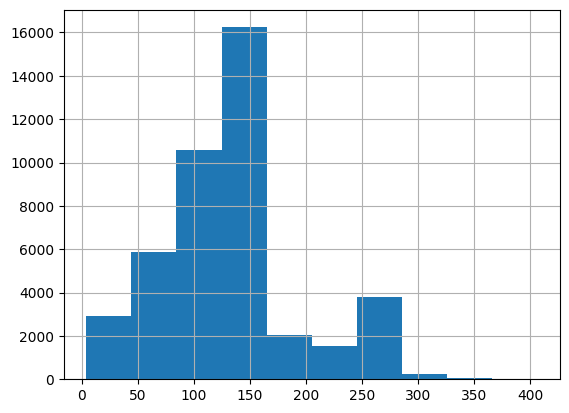

In [129]:
df['content'].str.len().hist()

In [130]:
# Let's prepare the data for BERTopic - discuss options for cleaning the text

# remove pics and videos - this does not work as expected - https://stackoverflow.com/questions/59970396/how-to-remove-picture-url-from-twitter-tweet-using-python
df['content'] = df['content'].str.replace(r'pic.twitter.com/[\w]*',"", regex=True)

In [131]:
# remove special characters
df['content'] = df['content'].str.replace(r'[^\w\s]', '', regex=True)

In [132]:
# remove numbers
df['content'] = df['content'].str.replace(r'\d+', '', regex=True)

In [133]:
# remove stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))

[nltk_data] Downloading package stopwords to /home/zach/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [134]:
# remove social media handles that start with @
df['content'] = df['content'].str.replace(r'@\w+', '', regex=True)

In [135]:
# remove urls 
df['content'] = df['content'].str.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'https\S+', '', regex=True)

In [136]:
df

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,sure tune watch Donald Trump Late Night David ...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump appearing View tomorrow morning d...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips Late...,2009-05-08 08:38:08,13,19,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post Celebrity Apprentice Finale Less...,2009-05-08 15:40:15,11,26,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,persona never wallflower Id rather build walls...,2009-05-12 09:07:28,1375,1945,NaN,NaN
...,...,...,...,...,...,...,...,...
43347,1273405198698975232,https://twitter.com/realDonaldTrump/status/127...,Joe Biden TOTAL FAILURE Government bungled eve...,2020-06-17 19:00:32,23402,116377,NaN,NaN
43348,1273408026968457216,https://twitter.com/realDonaldTrump/status/127...,interviewed seanhannity tonight PM Enjoy,2020-06-17 19:11:47,11810,56659,@seanhannity,NaN
43349,1273442195161387008,https://twitter.com/realDonaldTrump/status/127...,,2020-06-17 21:27:33,4959,19344,NaN,NaN
43350,1273442469066276864,https://twitter.com/realDonaldTrump/status/127...,,2020-06-17 21:28:38,4627,17022,NaN,NaN


In [137]:
# drop the rows with empty content
df = df[df['content'] != '']

In [138]:
# drop the rows with fewer than 5 words 
df = df[df['content'].str.split().str.len() > 6]

In [139]:
df

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,sure tune watch Donald Trump Late Night David ...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump appearing View tomorrow morning d...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips Late...,2009-05-08 08:38:08,13,19,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post Celebrity Apprentice Finale Less...,2009-05-08 15:40:15,11,26,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,persona never wallflower Id rather build walls...,2009-05-12 09:07:28,1375,1945,NaN,NaN
...,...,...,...,...,...,...,...,...
43341,1273032175718449155,https://twitter.com/realDonaldTrump/status/127...,Chris Jacobs JacobsNY tremendous Congressman a...,2020-06-16 18:18:17,9802,35418,@JacobsNY27,#NY27https
43342,1273034110353707008,https://twitter.com/realDonaldTrump/status/127...,Congressman LeeZeldin fighter New York serves ...,2020-06-16 18:25:58,12070,45048,@LeeZeldin,NaN
43343,1273038952275095558,https://twitter.com/realDonaldTrump/status/127...,LyndaBennettNC Complete Total Endorsement grea...,2020-06-16 18:45:12,10263,37476,@LyndaBennettNC,NaN
43345,1273080720794279937,https://twitter.com/realDonaldTrump/status/127...,GREAT woman son looking heaven proud wonderful...,2020-06-16 21:31:11,26468,112140,NaN,NaN


# Let's fit a topic model to the data 

In [140]:
# Bertopic requires a list of strings as input.
# 
# We'll call this list of strings 'documents'

documents = df['content'].tolist()

documents[0:10]

['sure tune watch Donald Trump Late Night David Letterman presents Top Ten List tonight',
 'Donald Trump appearing View tomorrow morning discuss Celebrity Apprentice new book Think Like Champion',
 'Donald Trump reads Top Ten Financial Tips Late Show David Letterman  funny',
 'New Blog Post Celebrity Apprentice Finale Lessons Learned Along Way ',
 'persona never wallflower Id rather build walls cling Donald J Trump',
 'Miss USA Tara Conner fired Ive always believer second chances says Donald Trump',
 'Listen interview Donald Trump discussing new book Think Like Champion ',
 'Strive wholeness keep sense wonder intact Donald J Trump ',
 'Enter Think Like Champion signed book keychain contest ',
 'achiever achieves plateau beginning Donald J Trump ']

In [141]:
# create a BERTopic model
topic_model = BERTopic()

# fit the model to the data
topics, probs = topic_model.fit_transform(documents)

In [142]:
# After generating topics, we can access the frequent topics that were generated

topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14443,-1_realdonaldtrump_trump_president_donald,"[realdonaldtrump, trump, president, donald, gr...",[Received many Congratulations many Big Victor...
1,0,464,0_china_chinese_chinas_tariffs,"[china, chinese, chinas, tariffs, currency, tr...",[China buys MUCH less us buy almost Billion Do...
2,1,335,1_veterans_honor_heroes_men,"[veterans, honor, heroes, men, women, service,...",[Tonight gathered celebrate courageous men wom...
3,2,330,2_poll_polls_lead_debate,"[poll, polls, lead, debate, carson, numbers, i...",[CNN Poll came amazing numbers want MAKE AMERI...
4,3,300,3_nytimes_media_failing_fake,"[nytimes, media, failing, fake, sources, news,...",[failing nytimes writes total fiction concerni...
...,...,...,...,...,...
401,400,10,400_ireland_investor_turnberryit_sharonsmurfit,"[ireland, investor, turnberryit, sharonsmurfit...",[SharonSmurfit realDonaldTrump Great purchase ...
402,401,10,401_forest_california_fires_management,"[forest, california, fires, management, burns,...",[proper Forest Management stop devastation con...
403,402,10,402_tiger_red_course_trumpdoral,"[tiger, red, course, trumpdoral, inveruriehera...",[new Red Tiger course TrumpDoral Follow Trump...
404,403,10,403_activism_safety_unsafe_security,"[activism, safety, unsafe, security, judicial,...",[many opposing view Border Safety cases filed ...


In [143]:

# create a BERTopic model
topic_model = BERTopic(nr_topics=20)

# fit the model to the data
topics, probs = topic_model.fit_transform(documents)

In [144]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14597,-1_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, tha...",[PeritusTraining realDonaldTrump Donald cant p...
1,0,8895,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, run...",[M_Foresta realDonaldTrump Id think make great...
2,1,2125,1_china_us_iran_trade,"[china, us, iran, trade, korea, north, deal, t...",[great confidence China properly deal North Ko...
3,2,2080,2_obamacare_obama_barackobama_tax,"[obamacare, obama, barackobama, tax, jobs, eco...",[Stock Market hit another record high Jobs loo...
4,3,1370,3_border_mexico_wall_people,"[border, mexico, wall, people, ebola, country,...",[Border Patrol Law Enforcement apprehended cap...
5,4,1345,4_golf_trump_macys_course,"[golf, trump, macys, course, hotel, doral, tie...",[Im Scotland open hope greatest golf course wo...
6,5,1273,5_great_honor_today_thank,"[great, honor, today, thank, happy, veterans, ...","[White House Press Conference today PM Thank, ..."
7,6,950,6_entrepreneurs_think_keep_big,"[entrepreneurs, think, keep, big, success, foc...",[problem government create real jobs entrepren...
8,7,791,7_yankees_nfl_great_wwe,"[yankees, nfl, great, wwe, nflcommish, dannyzu...","[Via WWE Donald Trump announced WWE Hall Fame,..."
9,8,229,8_wind_turbines_alexsalmond_scotland,"[wind, turbines, alexsalmond, scotland, ugly, ...",[First Minister AlexSalmond destroying beauty ...


In [146]:
topic_model.get_topic(16)

[('lordsugar', np.float64(0.46376850064593494)),
 ('sugar', np.float64(0.3650467268201899)),
 ('dopey', np.float64(0.2644470638279822)),
 ('worth', np.float64(0.08251364742767488)),
 ('show', np.float64(0.0823198073533679)),
 ('money', np.float64(0.05471870427159346)),
 ('ipod', np.float64(0.05436048071930963)),
 ('piersmorgan', np.float64(0.053719021143290906)),
 ('cant', np.float64(0.050812927701900844)),
 ('making', np.float64(0.050104705313644096))]

In [147]:
# -1 refers to all outliers and should typically be ignored.

# Using .get_document_info, we can also extract information on a document level, 
# such as their corresponding topics, probabilities, whether they are representative documents for a topic, etc.:

topic_model.get_document_info(documents)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,sure tune watch Donald Trump Late Night David ...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, run...",[M_Foresta realDonaldTrump Id think make great...,realdonaldtrump - trump - great - president - ...,0.410069,False
1,Donald Trump appearing View tomorrow morning d...,-1,-1_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, tha...",[PeritusTraining realDonaldTrump Donald cant p...,realdonaldtrump - trump - great - president - ...,0.000000,False
2,Donald Trump reads Top Ten Financial Tips Late...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, run...",[M_Foresta realDonaldTrump Id think make great...,realdonaldtrump - trump - great - president - ...,0.219888,False
3,New Blog Post Celebrity Apprentice Finale Less...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, run...",[M_Foresta realDonaldTrump Id think make great...,realdonaldtrump - trump - great - president - ...,0.401477,False
4,persona never wallflower Id rather build walls...,-1,-1_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, tha...",[PeritusTraining realDonaldTrump Donald cant p...,realdonaldtrump - trump - great - president - ...,0.000000,False
...,...,...,...,...,...,...,...,...
34474,Chris Jacobs JacobsNY tremendous Congressman a...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, run...",[M_Foresta realDonaldTrump Id think make great...,realdonaldtrump - trump - great - president - ...,0.855200,False
34475,Congressman LeeZeldin fighter New York serves ...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, run...",[M_Foresta realDonaldTrump Id think make great...,realdonaldtrump - trump - great - president - ...,0.507853,False
34476,LyndaBennettNC Complete Total Endorsement grea...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, run...",[M_Foresta realDonaldTrump Id think make great...,realdonaldtrump - trump - great - president - ...,0.435526,False
34477,GREAT woman son looking heaven proud wonderful...,0,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, run...",[M_Foresta realDonaldTrump Id think make great...,realdonaldtrump - trump - great - president - ...,0.644987,False


In [148]:
# We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other. To visualize this hierarchy, run the following:

topic_model.visualize_barchart(top_n_topics=20)

In [149]:
topic_model.visualize_topics()

In [150]:
# Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other. To visualize the heatmap, run the following:

topic_model.visualize_heatmap()

In [176]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14597,-1_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, tha...",[PeritusTraining realDonaldTrump Donald cant p...
1,0,8895,0_realdonaldtrump_trump_great_president,"[realdonaldtrump, trump, great, president, run...",[M_Foresta realDonaldTrump Id think make great...
2,1,2125,1_china_us_iran_trade,"[china, us, iran, trade, korea, north, deal, t...",[great confidence China properly deal North Ko...
3,2,2080,2_obamacare_obama_barackobama_tax,"[obamacare, obama, barackobama, tax, jobs, eco...",[Stock Market hit another record high Jobs loo...
4,3,1370,3_border_mexico_wall_people,"[border, mexico, wall, people, ebola, country,...",[Border Patrol Law Enforcement apprehended cap...
5,4,1345,4_golf_trump_macys_course,"[golf, trump, macys, course, hotel, doral, tie...",[Im Scotland open hope greatest golf course wo...
6,5,1273,5_great_honor_today_thank,"[great, honor, today, thank, happy, veterans, ...","[White House Press Conference today PM Thank, ..."
7,6,950,6_entrepreneurs_think_keep_big,"[entrepreneurs, think, keep, big, success, foc...",[problem government create real jobs entrepren...
8,7,791,7_yankees_nfl_great_wwe,"[yankees, nfl, great, wwe, nflcommish, dannyzu...","[Via WWE Donald Trump announced WWE Hall Fame,..."
9,8,229,8_wind_turbines_alexsalmond_scotland,"[wind, turbines, alexsalmond, scotland, ugly, ...",[First Minister AlexSalmond destroying beauty ...


# Dynamic topic modeling 

In [186]:
# create date column 
df['date'] = pd.to_datetime(df['date'])


# create two lists, one for date and one for text 

dates = df['date'].dt.year.tolist()
texts = df['content'].tolist()

In [190]:
# define and fit the model
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(texts)

# add the time dimension to the topics
topics_over_time = topic_model.topics_over_time(texts, dates, nr_bins=20)

In [191]:
# visualize the topics over time
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

# Handling topic names 

Our topic names are not the most informative, and we might want to re-label them to be more informative. We can do this by using several different methods

In [203]:
# define and fit the model
topic_model = BERTopic(verbose=True, nr_topics=50)
topics, probs = topic_model.fit_transform(texts)

2025-01-27 09:59:43,322 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1078 [00:00<?, ?it/s]

2025-01-27 09:59:48,600 - BERTopic - Embedding - Completed ✓
2025-01-27 09:59:48,601 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-27 09:59:51,684 - BERTopic - Dimensionality - Completed ✓
2025-01-27 09:59:51,685 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-27 09:59:52,193 - BERTopic - Cluster - Completed ✓
2025-01-27 09:59:52,194 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-27 09:59:52,468 - BERTopic - Representation - Completed ✓
2025-01-27 09:59:52,469 - BERTopic - Topic reduction - Reducing number of topics
2025-01-27 09:59:52,643 - BERTopic - Topic reduction - Reduced number of topics from 401 to 50


In [204]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,13311,-1_realdonaldtrump_great_trump_people,"[realdonaldtrump, great, trump, people, thank,...",[team negotiating always change deal end benef...
1,0,5743,0_realdonaldtrump_trump_run_president,"[realdonaldtrump, trump, run, president, donal...",[ILOVEBRITNEY_ realDonaldTrump could run presi...
2,1,4060,1_fake_news_hillary_poll,"[fake, news, hillary, poll, media, cnn, democr...",[House Democrats unable get even single vote R...
3,2,1473,2_china_trade_us_jobs,"[china, trade, us, jobs, tariffs, market, coun...",[reason US Consumer pay Tariffs take effect Ch...
4,3,1153,3_golf_hotel_course_doral,"[golf, hotel, course, doral, trump, scotland, ...",[going Trump National Doral Miami early today ...
5,4,1000,4_honor_iowa_today_great,"[honor, iowa, today, great, veterans, thank, h...",[Today Alaska great honor visit brave men wome...
6,5,849,5_iran_syria_isis_iraq,"[iran, syria, isis, iraq, obama, israel, attac...",[Likewise want Kurds provoke Turkey Russia Ira...
7,6,595,6_obamacare_tax_daca_cuts,"[obamacare, tax, daca, cuts, healthcare, websi...",[immediately repeal replace ObamaCare nobody l...
8,7,584,7_border_wall_mexico_immigration,"[border, wall, mexico, immigration, southern, ...",[Without Wall cannot safety security Border US...
9,8,584,8_endorsement_vets_amendment_complete,"[endorsement, vets, amendment, complete, gover...",[Governor MattBevin done wonderful job people ...


In [223]:
# the easiest way to generate topic labels is to use the generate_topic_labels method

topic_model.generate_topic_labels(nr_words=10,topic_prefix=False,word_length=15,separator=", ")

['realdonaldtrump, great, trump, people, thank, big, get, obama, like, donald',
 'realdonaldtrump, trump, run, president, donald, thanks, please, apprentice, need, great',
 'fake, news, hillary, poll, media, cnn, democrats, clinton, crooked, collusion',
 'china, trade, us, jobs, tariffs, market, countries, chinese, economy, stock',
 'golf, hotel, course, doral, trump, scotland, club, national, best, links',
 'honor, iowa, today, great, veterans, thank, hampshire, day, women, crowd',
 'iran, syria, isis, iraq, obama, israel, attack, us, iranian, benghazi',
 'obamacare, tax, daca, cuts, healthcare, website, repeal, republicans, premiums, cut',
 'border, wall, mexico, immigration, southern, democrats, security, rico, puerto, borders',
 'endorsement, vets, amendment, complete, governor, crime, strong, carolina, total, military',
 'enforcement, police, law, prayers, families, fema, hurricane, responders, gun, state',
 'barackobama, obama, barackobamas, debt, college, records, obamas, charit

## More advanced: use a language model to generate topic names

In [226]:
topic_names = topic_model.generate_topic_labels(nr_words=10,topic_prefix=False,word_length=15,separator=", ")
topic_names

['realdonaldtrump, great, trump, people, thank, big, get, obama, like, donald',
 'realdonaldtrump, trump, run, president, donald, thanks, please, apprentice, need, great',
 'fake, news, hillary, poll, media, cnn, democrats, clinton, crooked, collusion',
 'china, trade, us, jobs, tariffs, market, countries, chinese, economy, stock',
 'golf, hotel, course, doral, trump, scotland, club, national, best, links',
 'honor, iowa, today, great, veterans, thank, hampshire, day, women, crowd',
 'iran, syria, isis, iraq, obama, israel, attack, us, iranian, benghazi',
 'obamacare, tax, daca, cuts, healthcare, website, repeal, republicans, premiums, cut',
 'border, wall, mexico, immigration, southern, democrats, security, rico, puerto, borders',
 'endorsement, vets, amendment, complete, governor, crime, strong, carolina, total, military',
 'enforcement, police, law, prayers, families, fema, hurricane, responders, gun, state',
 'barackobama, obama, barackobamas, debt, college, records, obamas, charit

In [227]:
pip install openai

  Using cached openai-1.60.1-py3-none-any.whl.metadata (27 kB)
  Using cached anyio-4.8.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached jiter-0.8.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.2 kB)
  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached httpcore-1.0.7-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.27.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
Using cached openai-1.60.1-py3-none-any.whl (456 kB)
Using cached anyio-4.8.0-py3-none-any.whl (96 kB)
Using cached distro-1.9.0-py3-none-any.whl (20 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Us

In [228]:
# import openai API 
from openai import OpenAI


# create an instance of the OpenAI class - we're not going to use the API key, but it is required
client = OpenAI(
    base_url='http://localhost:11434/v1/',
    api_key='ollama',  # Required but ignored
)

In [258]:

# define the model we want to use
model = 'mistral'


# write a function that takes a string as input and returns the chatbot's response
def chat(text): 
    chat_completion = client.chat.completions.create(
        messages=[
            {'role': 'user', 'content': text},
        ],
        model=model, 
    )
    
    response = chat_completion.choices[0].message.content
    
    # print the response with line breaks
    print(response)
    return response

In [253]:
chat(f''' I am going to give you the topic representation words for a topic model. I want you to generate a label for the topic. Please only reply with a label for the topic. Here are the words: 
     
     \n \n 
     
        {topic_names[2]}
        
        
     \n \n    

    
        
    ''')

 Controversial U.S. Politics: Allegations and Media Coverage (2016 Presidential Election Focus)


In [255]:
from tqdm import tqdm

In [263]:
new_llm_topic_names = []

for i in tqdm(topic_names): 
    response = chat(f''' I am going to give you the topic representation words for a topic model. I want you to generate a label for the topic. Please only reply with a label for the topic. Here are the words: 
     
     \n \n 
     
        {i}
        
        
     \n \n    

    
        
    ''')
    
    new_llm_topic_names.append(response)

  4%|▍         | 2/50 [00:00<00:08,  5.57it/s]

 Trump Rally / Supporters Appreciation
 "Trump Campaign/Supporters"


  6%|▌         | 3/50 [00:00<00:12,  3.89it/s]

 Controversial Political News (Conspiracy Theories) - Hillary Clinton & Collusion


  8%|▊         | 4/50 [00:00<00:11,  4.05it/s]

 "US-China Trade Relations & Economic Impact"


 12%|█▏        | 6/50 [00:01<00:10,  4.19it/s]

 "Luxury Golf Travel: Premium Courses and Hotels"
 "Iowa Veterans Appreciation Day"


 14%|█▍        | 7/50 [00:01<00:12,  3.36it/s]

 Middle East Conflicts and U.S. Foreign Policy (2010-2016)


 16%|█▌        | 8/50 [00:02<00:12,  3.48it/s]

 "Political Debates on Healthcare and Tax Policies"


 18%|█▊        | 9/50 [00:02<00:11,  3.63it/s]

 Border Security and Immigration Policy (US - Mexico Region)


 22%|██▏       | 11/50 [00:02<00:10,  3.68it/s]

 Topic Label: "Political Issues in North Carolina - Military and Legislation"
 "Disaster Response and Law Enforcement"


 24%|██▍       | 12/50 [00:03<00:09,  4.08it/s]

 Barack Obama Elections and Charity Record


 26%|██▌       | 13/50 [00:03<00:08,  4.14it/s]

 Entrepreneurial Innovation and Focused Success Strategies


 28%|██▊       | 14/50 [00:03<00:09,  3.63it/s]

 "Controversial Wind Energy in Scotland Amidst Global Warming Debate"


 32%|███▏      | 16/50 [00:04<00:10,  3.29it/s]

 Law and Judiciary (specifically related to the U.S. Supreme Court with focus on Schneiderman, Roberts, and a significant legal case)
 Artistic Literary Pursuits


 34%|███▍      | 17/50 [00:04<00:09,  3.53it/s]

 Unified Strength of America (Past & Present)


 38%|███▊      | 19/50 [00:05<00:07,  3.98it/s]

 "Pro Wrestling Legends and their Achievements"
 Global Health Crisis (Travel & Africa)


 40%|████      | 20/50 [00:05<00:07,  4.14it/s]

 "NFL Protests and Buffalo Bills News"


 42%|████▏     | 21/50 [00:05<00:07,  3.93it/s]

 Topic: North Korea Nuclear Policy & Summit Negotiations


 44%|████▍     | 22/50 [00:05<00:07,  3.73it/s]

 Sports Topic: New York Yankees - Legends and Contemporary Stars


 46%|████▌     | 23/50 [00:06<00:06,  3.95it/s]

 "Desperate Art Deals Negotiations"


 48%|████▊     | 24/50 [00:06<00:06,  3.88it/s]

 Sports Betting and Celebrity Influence in Cuban Affairs


 50%|█████     | 25/50 [00:06<00:06,  3.92it/s]

 **Political Fundraising and Special Interest Influence**


 54%|█████▍    | 27/50 [00:07<00:05,  4.05it/s]

 "Real Estate Bankruptcies in Major Cities: Buying Properties Post-Bankruptcy"
 Holiday & Global Celebrations


 56%|█████▌    | 28/50 [00:07<00:06,  3.67it/s]

 Travel and Politics (Colorado, Dallas, Ohio, Maga related topics, Airlines)


 58%|█████▊    | 29/50 [00:07<00:05,  3.56it/s]

 Food & Entertainment Magazine Sales & Circulation (Graydon Carter Edition)


 60%|██████    | 30/50 [00:08<00:05,  3.62it/s]

 Presidential Campaign Rivalries (or simply Campaign Rivalries)


 62%|██████▏   | 31/50 [00:08<00:05,  3.34it/s]

 Topic Label: Autism Awareness and Vaccination Concerns among Children


 64%|██████▍   | 32/50 [00:08<00:05,  3.58it/s]

 Scandalous Politicians and Sexual Misconduct Scandal


 66%|██████▌   | 33/50 [00:08<00:04,  3.69it/s]

 Celebrity Apprentice Contestants (or similar)


 68%|██████▊   | 34/50 [00:09<00:04,  3.78it/s]

 "Federal Transportation Funding for Recovery Projects"


 70%|███████   | 35/50 [00:09<00:03,  3.92it/s]

 Social Media Engagement and User Interaction with Public Figures


 74%|███████▍  | 37/50 [00:10<00:03,  3.57it/s]

 Opioid Crisis: Prices and Fighting for Prescription Drug Takeback Day (Pfizer-related)
 Celebrity Scandals and Personal Interviews


 76%|███████▌  | 38/50 [00:10<00:03,  3.76it/s]

 "Celebrity Culture and Controversies"


 80%|████████  | 40/50 [00:10<00:02,  4.03it/s]

 Controversial News Critique (or) Anti-Biden Media Analysis
 "Tech Competition and Environmental Impact"


 82%|████████▏ | 41/50 [00:11<00:02,  3.87it/s]

 "Intelligent Car Design Discussions - Ford and Henry Ford"


 84%|████████▍ | 42/50 [00:11<00:02,  3.16it/s]

 Controversial T-Mobile Discussions: Competitors, Service Critiques, and Celebrity Endorsements


 86%|████████▌ | 43/50 [00:11<00:02,  3.26it/s]

 Aerospace Industry Mergers and Lithium-ion Batteries


 88%|████████▊ | 44/50 [00:12<00:02,  2.37it/s]

 Dubai Property Development (or similar label like "Dubai Real Estate Projects", "Dubai Property Market updates" or "Investment Opportunities in Dubai Properties")


 90%|█████████ | 45/50 [00:12<00:02,  2.44it/s]

 "USGA Green Renovation at Pinehurst Resort - Golf Course Improvements"
 Military and Politics


 94%|█████████▍| 47/50 [00:13<00:00,  3.20it/s]

 Military Sexual Misconduct (MSM) or Armed Forces Assault/Abuse


 96%|█████████▌| 48/50 [00:13<00:00,  3.41it/s]

 "Political News (Conservative Bias)"


 98%|█████████▊| 49/50 [00:13<00:00,  3.28it/s]

 "Presidential Orders Regarding Kidney Improvement and American Military Antiquities"


100%|██████████| 50/50 [00:14<00:00,  3.55it/s]

 Topic Label: "Connecticut Politics and Vietnam Veterans"


In [265]:
new_llm_topic_names

[' Trump Rally / Supporters Appreciation',
 ' "Trump Campaign/Supporters"',
 ' Controversial Political News (Conspiracy Theories) - Hillary Clinton & Collusion',
 ' "US-China Trade Relations & Economic Impact"',
 ' "Luxury Golf Travel: Premium Courses and Hotels"',
 ' "Iowa Veterans Appreciation Day"',
 ' Middle East Conflicts and U.S. Foreign Policy (2010-2016)',
 ' "Political Debates on Healthcare and Tax Policies"',
 ' Border Security and Immigration Policy (US - Mexico Region)',
 ' Topic Label: "Political Issues in North Carolina - Military and Legislation"',
 ' "Disaster Response and Law Enforcement"',
 ' Barack Obama Elections and Charity Record',
 ' Entrepreneurial Innovation and Focused Success Strategies',
 ' "Controversial Wind Energy in Scotland Amidst Global Warming Debate"',
 ' Law and Judiciary (specifically related to the U.S. Supreme Court with focus on Schneiderman, Roberts, and a significant legal case)',
 ' Artistic Literary Pursuits',
 ' Unified Strength of America 

In [269]:
topics = topic_model.get_topic_info()
topics['refined_topic_names'] = new_llm_topic_names

In [270]:
topics

,Topic,Count,Name,Representation,Representative_Docs,refined_topic_names
0,-1,13311,-1_realdonaldtrump_great_trump_people,"[realdonaldtrump, great, trump, people, thank,...",[team negotiating always change deal end benef...,Trump Rally / Supporters Appreciation
1,0,5743,0_realdonaldtrump_trump_run_president,"[realdonaldtrump, trump, run, president, donal...",[ILOVEBRITNEY_ realDonaldTrump could run presi...,"""Trump Campaign/Supporters"""
2,1,4060,1_fake_news_hillary_poll,"[fake, news, hillary, poll, media, cnn, democr...",[House Democrats unable get even single vote R...,Controversial Political News (Conspiracy Theo...
3,2,1473,2_china_trade_us_jobs,"[china, trade, us, jobs, tariffs, market, coun...",[reason US Consumer pay Tariffs take effect Ch...,"""US-China Trade Relations & Economic Impact"""
4,3,1153,3_golf_hotel_course_doral,"[golf, hotel, course, doral, trump, scotland, ...",[going Trump National Doral Miami early today ...,"""Luxury Golf Travel: Premium Courses and Hotels"""
5,4,1000,4_honor_iowa_today_great,"[honor, iowa, today, great, veterans, thank, h...",[Today Alaska great honor visit brave men wome...,"""Iowa Veterans Appreciation Day"""
6,5,849,5_iran_syria_isis_iraq,"[iran, syria, isis, iraq, obama, israel, attac...",[Likewise want Kurds provoke Turkey Russia Ira...,Middle East Conflicts and U.S. Foreign Policy...
7,6,595,6_obamacare_tax_daca_cuts,"[obamacare, tax, daca, cuts, healthcare, websi...",[immediately repeal replace ObamaCare nobody l...,"""Political Debates on Healthcare and Tax Poli..."
8,7,584,7_border_wall_mexico_immigration,"[border, wall, mexico, immigration, southern, ...",[Without Wall cannot safety security Border US...,Border Security and Immigration Policy (US - ...
9,8,584,8_endorsement_vets_amendment_complete,"[endorsement, vets, amendment, complete, gover...",[Governor MattBevin done wonderful job people ...,"Topic Label: ""Political Issues in North Carol..."
